# Final Project Check-in 2018-11-16

## Group Name: The Placeholders

### Student Names


1. Aditi Sharma
2. Jyoti Prakash Maheswari
3. Joy Wenjing Qi
4. Xinke Sun
5. Zhe Yuan

In [1]:
# Import all import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from summary_fn import *

# Load Data

In [2]:
# Read all the data files
train = pd.read_csv('train.csv')
member = pd.read_csv('members.csv', parse_dates=[
                     'registration_init_time', 'expiration_date'])
songs = pd.read_csv('songs.csv')
extra_song = pd.read_csv('song_extra_info.csv')
test = pd.read_csv('test.csv')

In [5]:
# Convert city and registered_via into category
member.city = member.city.astype('category')
member.registered_via = member.registered_via.astype('category')

In [8]:
# Convert language to category
songs.language = songs.language.astype('category')

In [9]:
# Function to convert all object columns to category type
def convert_obj_cat(df):
    obj_cols = df.select_dtypes(include='object').columns
    for col in obj_cols:
        df[col] = df[col].astype('category')

In [10]:
convert_obj_cat(train)
convert_obj_cat(test)
convert_obj_cat(songs)
convert_obj_cat(member)
convert_obj_cat(extra_song)

In [11]:
# Merge all required files into a single file
train = train.merge(songs, how='left', on='song_id')
test = test.merge(songs, how='left', on='song_id')

In [12]:
train = train.merge(member, how='left', on='msno')
test = test.merge(member, how='left', on='msno')

In [13]:
train = train.merge(extra_song, how='left', on='song_id')
test = test.merge(extra_song, how='left', on='song_id')

In [18]:
# Feature extractions
train['days_left'] = (train.expiration_date -
                      train.registration_init_time).dt.days.astype('int')

In [19]:
train['reg_year'] = train['registration_init_time'].dt.year
train['reg_month'] = train['registration_init_time'].dt.month
train['reg_date'] = train['registration_init_time'].dt.day

train['exp_year'] = train['expiration_date'].dt.year
train['exp_month'] = train['expiration_date'].dt.month
train['exp_date'] = train['expiration_date'].dt.day

In [20]:
# Drop expiration date and registration date columns
train.drop(columns=['registration_init_time',
                    'expiration_date'], index=1, inplace=True)

In [21]:
# Use isrc to extract years
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan


train['song_year'] = train['isrc'].apply(isrc_to_year)

# Drop isrc and name
train.drop(['isrc', 'name'], axis=1, inplace=True)

In [22]:
# Counted features
def gener_id_count(x):
    if pd.isnull(x):
        return x
    else:
        return x.count('|')+1


def lyricist_count(x):
    if pd.isnull(x):
        return x
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1


def composer_count(x):
    if pd.isnull(x):
        return x
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1


def artist_count(x):
    if pd.isnull(x):
        return x
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1


def is_featured(x):
    if 'feat' in str(x):
        return 1
    return 0

In [23]:
train['gener_count'] = train['genre_ids'].apply(gener_id_count).astype(np.int8)
train['lyricist_count'] = train['lyricist'].apply(
    lyricist_count).astype(np.int8)
train['composer_count'] = train['composer'].apply(
    composer_count).astype(np.int8)
train['artist_count'] = train['artist_name'].apply(
    artist_count).astype(np.int8)
train['features'] = train['artist_name'].apply(is_featured).astype(np.int8)

In [24]:
# Number of times a song is played
song_count = song_play_times(train['song_id'])

In [25]:
song_count_df = pd.DataFrame.from_dict(
    song_count, orient='index', columns=['counts'])

In [26]:
song_count_df.reset_index(level=0, inplace=True)

In [27]:
song_count_df = song_count_df.rename(columns={'index': 'song_id'})

In [28]:
train = train.merge(song_count_df, how='left', on='song_id')

In [30]:
# Count artist counts similarly
artist_count = pd.DataFrame.from_dict(song_play_times(train['artist_name']),
                                      orient='index', columns=['artist_song_count']).reset_index()
artist_count = artist_count.rename(columns={'index': 'artist_name'})

In [31]:
train = train.merge(artist_count, how='left', on='artist_name')

# Fit scikit-learn model

In [34]:
# Build models
y_train = train['target']
x_train = train.drop(['target'], axis=1)
convert_obj_cat(x_train)

In [35]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in x_train.columns:
    if x_train[column_name].dtype.name == 'category':
        x_train[column_name] = le.fit_transform(
            x_train[column_name].astype(str))
    else:
        pass

In [36]:
x_train = x_train.fillna(-1)

In [37]:
x_train.shape

(7377417, 30)

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(
    x_train, y_train, test_size=0.8)

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=100, oob_score=False, n_jobs=-1)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

# Evaluation Metric

In [48]:
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
print(f'Mean accuracy score: {accuracy:.3}')

Mean accuracy score: 0.697


In [49]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(Y_test, predicted)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.7  0.69]
recall: [0.67 0.72]
fscore: [0.69 0.71]
support: [2930782 2971152]


We can see that our model performs significantly better than base line model(majority or random chance model with accuracy 50%). We can work on feature engineering and model hyper-parameters to imporve the performace.

Confusion matrix, without normalization
[[1967497  963285]
 [ 827935 2143217]]
Normalized confusion matrix
[[0.67 0.33]
 [0.28 0.72]]


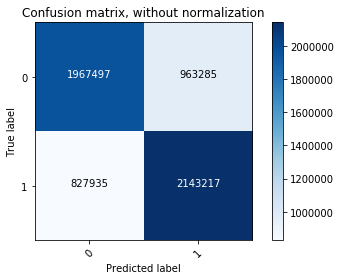

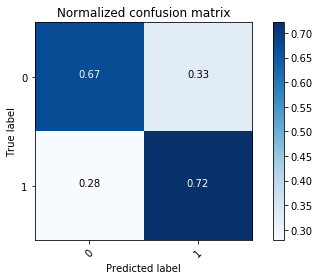

In [50]:
import itertools
from sklearn.metrics import confusion_matrix

class_names = ['0', '1']


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()